In [ ]:
#Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc
import os
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
#Load the data
#!/bin/bash
!curl -L -o /root/sample.zip\
  https://www.kaggle.com/api/v1/datasets/download/nih-chest-xrays/sample

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4297M  100 4297M    0     0   105M      0  0:00:40  0:00:40 --:--:-- 36.2M


In [ ]:
data_path = '/root/sample.zip'

with ZipFile(data_path,'r') as zip_file:
  zip_file.extractall('/root/')
  print('The data set has been extracted.')

The data set has been extracted.


In [ ]:
# ../input/
PATH = os.path.abspath(os.path.join('root', 'sample'))

# ../input/sample/images/
SOURCE_IMAGES = '/root/sample/images/'

# ../input/sample/images/*.png
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

# Load labels
labels = pd.read_csv('/root/sample_labels.csv')

In [ ]:
images[0:5]

['/root/sample/images/00023309_015.png',
 '/root/sample/images/00000737_000.png',
 '/root/sample/images/00023316_004.png',
 '/root/sample/images/00021124_002.png',
 '/root/sample/images/00023770_000.png']

In [ ]:
SOURCE_IMAGES

'/root/sample/images/'

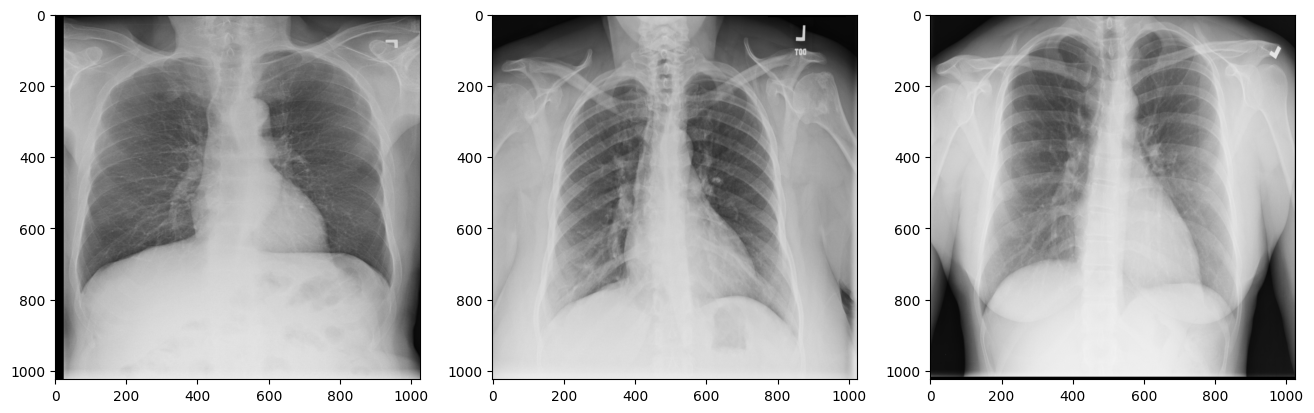

In [ ]:
r = random.sample(images, 3)
r

# Matplotlib black magic
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))

plt.subplot(132)
plt.imshow(cv2.imread(r[1]))

plt.subplot(133)
plt.imshow(cv2.imread(r[2]));

Counter({'No Finding': 3044, 'Infiltration': 503, 'Effusion': 203, 'Atelectasis': 192, 'Nodule': 144, 'Pneumothorax': 114, 'Mass': 99, 'Consolidation': 72, 'Effusion|Infiltration': 69, 'Pleural_Thickening': 65, 'Atelectasis|Infiltration': 57, 'Atelectasis|Effusion': 55, 'Cardiomegaly': 50, 'Infiltration|Nodule': 44, 'Emphysema': 42, 'Edema': 41, 'Fibrosis': 38, 'Atelectasis|Effusion|Infiltration': 31, 'Cardiomegaly|Effusion': 30, 'Infiltration|Mass': 29, 'Edema|Infiltration': 21, 'Effusion|Pneumothorax': 20, 'Infiltration|Pneumothorax': 19, 'Consolidation|Infiltration': 18, 'Mass|Nodule': 17, 'Mass|Pneumothorax': 16, 'Effusion|Mass': 16, 'Emphysema|Pneumothorax': 15, 'Atelectasis|Consolidation': 15, 'Effusion|Pleural_Thickening': 14, 'Pneumonia': 14, 'Infiltration|Pleural_Thickening': 12, 'Consolidation|Effusion': 12, 'Atelectasis|Nodule': 12, 'Atelectasis|Consolidation|Effusion': 11, 'Effusion|Nodule': 11, 'Cardiomegaly|Infiltration': 10, 'Edema|Effusion|Infiltration': 10, 'Consolidat

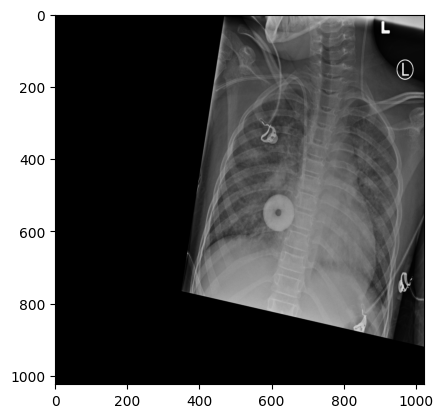

In [ ]:
from collections import Counter
e = cv2.imread(os.path.join(SOURCE_IMAGES,'00030209_008.png'))

plt.imshow(e)

labels = pd.read_csv('/root/sample_labels.csv')
labels[labels["Image Index"] == '00030209_008.png']
summary = Counter(labels['Finding Labels'])

print(summary)

In [ ]:
labels['label'] = labels['Finding Labels'].str.split('|').str[0]
labels
df_filtered = labels[labels['label'].isin(['No Finding', 'Effusion'])]

# Separate the two classes
df_class0 = df_filtered[df_filtered['label'] == 'No Finding']
df_class1 = df_filtered[df_filtered['label'] == 'Effusion']

# Find the smaller class size
min_size = min(len(df_class0), len(df_class1))

# Downsample both classes to the same size
df_class0_down = df_class0.sample(n=min_size, random_state=42)
df_class1_down = df_class1.sample(n=min_size, random_state=42)

# Combine and shuffle
labels = pd.concat([df_class0_down, df_class1_down]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
summary = Counter(labels['label'])

print(summary)

Counter({'Effusion': 393, 'No Finding': 393})


In [ ]:
def proc_images():
    """
    Returns two arrays:
        x is an array of resized images
        y is an array of labels
    """

    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 128
    HEIGHT = 128

    for img in images:
        base = os.path.basename(img)
        if base in list(labels["Image Index"]):
          finding = labels["label"][labels["Image Index"] == base].values[0]

          # Read and resize image
          full_size_image = cv2.imread(img)
          x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

          # Labels
          if finding == 'No Finding':
              y.append(0)
          else:
              y.append(1)
          #y.append(finding)

    return x,y

In [ ]:
X, y = proc_images()

In [ ]:
X = np.array(X)
y = np.array(y)
import numpy as np

# Find indices of each class
class0_indices = np.where(y == 0)[0]
class1_indices = np.where(y == 1)[0]

# Find smaller class size
min_size = min(len(class0_indices), len(class1_indices))

# Randomly sample from each class
np.random.seed(42)  # for reproducibility
class0_sample = np.random.choice(class0_indices, size=min_size, replace=False)
class1_sample = np.random.choice(class1_indices, size=min_size, replace=False)

# Combine and shuffle
balanced_indices = np.concatenate([class0_sample, class1_sample])
np.random.shuffle(balanced_indices)

# Balanced dataset
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]


In [ ]:
y[0:5]

array([0, 1, 1, 0, 1])

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [22, 22, 22],
        [21, 21, 21],
        [21, 21, 21]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [19, 19, 19],
        [19, 19, 19],
        [19, 19, 19]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [18, 18, 18],
        [18, 18, 18],
        [19, 19, 19]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [13, 13, 13],
        [13, 13, 13],
        [13, 13, 13]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [13, 13, 13],
        [13, 13, 13],
        [14, 14, 14]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [13, 13, 13],
        [14, 14, 14],
        [15, 15, 15]]], dtype=uint8)
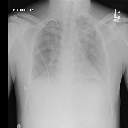

In [ ]:
X[3]

In [ ]:


# Step 1: Count class occurrences
class_counts = Counter(y)

# Step 2: Keep only classes with at least 10 samples
valid_classes = {cls for cls, count in class_counts.items() if count >= 10}

# Step 3: Filter X and y
X_filtered = [img for img, label in zip(X_balanced, y_balanced) if label in valid_classes]
y_filtered = [label for label in y_balanced if label in valid_classes]

# Step 4: Remap class labels to contiguous integers
# Create mapping from old label -> new label (0-based)
unique_classes = sorted(set(y_filtered))
label_map = {old: new for new, old in enumerate(unique_classes)}

# Step 5: Apply the mapping
y_remapped = [label_map[label] for label in y_filtered]
print(len(X_filtered))
print(len(y_remapped))

786
786


In [ ]:
import torchvision.transforms as T

# Step 1: Define transforms
train_transform = T.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Example normalization
])

val_transform = T.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # NumPy array (H, W, C)
        label = self.labels[idx]

        # Convert image to torch tensor and move channel to first dimension
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)

        if self.transform:
            image = self.transform(image)

        return image, label

array([[[ 22,  22,  22],
        [ 21,  21,  21],
        [ 21,  21,  21],
        ...,
        [ 20,  20,  20],
        [ 19,  19,  19],
        [ 19,  19,  19]],

       [[ 21,  21,  21],
        [ 20,  20,  20],
        [ 20,  20,  20],
        ...,
        [ 18,  18,  18],
        [ 18,  18,  18],
        [ 19,  19,  19]],

       [[ 21,  21,  21],
        [ 20,  20,  20],
        [ 20,  20,  20],
        ...,
        [ 18,  18,  18],
        [ 18,  18,  18],
        [ 19,  19,  19]],

       ...,

       [[140, 140, 140],
        [125, 125, 125],
        [116, 116, 116],
        ...,
        [141, 141, 141],
        [123, 123, 123],
        [105, 105, 105]],

       [[138, 138, 138],
        [127, 127, 127],
        [116, 116, 116],
        ...,
        [133, 133, 133],
        [119, 119, 119],
        [103, 103, 103]],

       [[136, 136, 136],
        [127, 127, 127],
        [113, 113, 113],
        ...,
        [138, 138, 138],
        [123, 123, 123],
        [105, 105, 105]]], dtype=uint8)
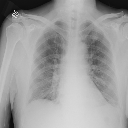

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    X_filtered, y_remapped, test_size=0.2, random_state=42
)
train_imgs[0]

In [ ]:
# Ensure inputs are numpy arrays
#train_imgs = np.array(train_imgs)
#train_labels = np.array(train_labels)

# Define the majority class (replace 0 if different)
#majority_class = 9

# Get indices for majority and minority class examples
#majority_indices = np.where(train_labels == majority_class)[0]
#minority_indices = np.where(train_labels != majority_class)[0]

# Determine how many majority examples to keep
# For example, make majority 10% of the total
#minority_count = len(minority_indices)
#desired_majority_count = int(0.1 * minority_count / 0.75)

# Downsample majority class
#np.random.shuffle(majority_indices)
#majority_indices_subset = majority_indices[:desired_majority_count]

# Combine the selected indices
#keep_indices = np.concatenate((minority_indices, majority_indices_subset))
#np.random.shuffle(keep_indices)

# Subset the images and labels using keep_indices
#train_imgs_balanced = train_imgs[keep_indices]
#train_labels_balanced = train_labels[keep_indices]

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

# Count how often each class appears
#train_class_counts = Counter(train_labels)

#train_sample_weights = [1.0 / train_class_counts[label] for label in train_labels]

# Initialize the sampler with the number of samples in the training set
#sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

train_dataset = ImageDataset(train_imgs, train_labels, transform=train_transform)
val_dataset = ImageDataset(val_imgs, val_labels, transform=val_transform)
#train_dataset = ImageDataset(train_imgs_balanced, train_labels_balanced, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)  # Reduces H,W by 2

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (32, 64, 64)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (64, 32, 32)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # -> (128, 16, 16)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # -> (256, 8, 8)
        x = x.view(x.size(0), -1)                       # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


net = Net(num_classes=len(np.unique(y_remapped)))

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
import torch.optim as optim

class_counts = Counter(y_remapped)
total = sum(class_counts.values())
num_classes = len(class_counts)

weights = torch.tensor(
    [1.0 / class_counts[i] for i in range(num_classes)],
    dtype=torch.float32
)
weights = weights / weights.sum() * num_classes  # Normalize

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = weights.to(device)
num_classes = len(set(y_remapped))  # or whatever your class count is

model = Net(num_classes=num_classes).to(device)
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

Epoch 1/100
  Train Loss: 4.8976 | Train Acc: 0.4713
  Val   Loss: 1.7590 | Val   Acc: 0.5000
Epoch 2/100
  Train Loss: 1.0872 | Train Acc: 0.5111
  Val   Loss: 1.0468 | Val   Acc: 0.5127
Epoch 3/100
  Train Loss: 0.7718 | Train Acc: 0.5621
  Val   Loss: 0.7243 | Val   Acc: 0.5380
Epoch 4/100
  Train Loss: 0.6923 | Train Acc: 0.5382
  Val   Loss: 0.7114 | Val   Acc: 0.6203
Epoch 5/100
  Train Loss: 0.6842 | Train Acc: 0.5669
  Val   Loss: 0.6936 | Val   Acc: 0.6139
Epoch 6/100
  Train Loss: 0.6567 | Train Acc: 0.6131
  Val   Loss: 0.6570 | Val   Acc: 0.6709
Epoch 7/100
  Train Loss: 0.6905 | Train Acc: 0.5892
  Val   Loss: 0.6723 | Val   Acc: 0.6329
Epoch 8/100
  Train Loss: 0.6652 | Train Acc: 0.5908
  Val   Loss: 0.6808 | Val   Acc: 0.5886
Epoch 9/100
  Train Loss: 0.6598 | Train Acc: 0.6051
  Val   Loss: 0.6661 | Val   Acc: 0.7089
Epoch 10/100
  Train Loss: 0.6435 | Train Acc: 0.6146
  Val   Loss: 0.6555 | Val   Acc: 0.7342
Epoch 11/100
  Train Loss: 0.6393 | Train Acc: 0.6354
  Val

KeyboardInterrupt: 

In [ ]:
np.unique(y_remapped)

array([0, 1])

In [ ]:
dataiter = iter(val_loader)
images, labels = next(dataiter)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print(labels)
print(predicted)

tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def get_all_preds(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())
    return preds, targets

preds, targets = get_all_preds(model, val_loader, device)
print(classification_report(targets, preds))
print(confusion_matrix(targets, preds))

              precision    recall  f1-score   support

           0       0.68      0.87      0.76        93
           1       0.86      0.66      0.74       111

    accuracy                           0.75       204
   macro avg       0.77      0.76      0.75       204
weighted avg       0.78      0.75      0.75       204

[[81 12]
 [38 73]]


### Now using a pretrained model and fine-tuning!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
class ResNetBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)

    def forward(self, x):
        return self.model(x)

model = ResNetBinary().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    return running_loss / len(loader.dataset), correct / len(loader.dataset)

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

            all_preds.extend(outputs.softmax(dim=1)[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    auc = roc_auc_score(all_labels, all_preds)
    return running_loss / len(loader.dataset), correct / len(loader.dataset), auc

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15
train_loss_list, train_acc_list, val_loss_list, val_acc_list, val_auc_list = [], [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_auc = evaluate(model, val_loader, criterion, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    val_auc_list.append(val_auc)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | AUC: {val_auc:.4f}")

Epoch 1/15
  Train Loss: 0.7167 | Train Acc: 0.5748
  Val   Loss: 0.6801 | Val   Acc: 0.6329 | AUC: 0.7049
Epoch 2/15
  Train Loss: 0.5734 | Train Acc: 0.7118
  Val   Loss: 0.6529 | Val   Acc: 0.6519 | AUC: 0.7312
Epoch 3/15
  Train Loss: 0.5075 | Train Acc: 0.7596
  Val   Loss: 0.6299 | Val   Acc: 0.7152 | AUC: 0.7899
Epoch 4/15
  Train Loss: 0.4849 | Train Acc: 0.7532
  Val   Loss: 0.6779 | Val   Acc: 0.6772 | AUC: 0.7436
Epoch 5/15
  Train Loss: 0.4789 | Train Acc: 0.7755
  Val   Loss: 0.7474 | Val   Acc: 0.6013 | AUC: 0.6988
Epoch 6/15
  Train Loss: 0.4094 | Train Acc: 0.8105
  Val   Loss: 0.7121 | Val   Acc: 0.7025 | AUC: 0.7287
Epoch 7/15
  Train Loss: 0.3722 | Train Acc: 0.8296
  Val   Loss: 0.6689 | Val   Acc: 0.7152 | AUC: 0.7536
Epoch 8/15
  Train Loss: 0.3287 | Train Acc: 0.8678
  Val   Loss: 0.6913 | Val   Acc: 0.7025 | AUC: 0.7687
Epoch 9/15
  Train Loss: 0.3326 | Train Acc: 0.8615
  Val   Loss: 0.6912 | Val   Acc: 0.7089 | AUC: 0.7563
Epoch 10/15
  Train Loss: 0.3522 | Tr

In [ ]:
def get_all_preds(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())
    return preds, targets

preds, targets = get_all_preds(model, val_loader, device)
print(classification_report(targets, preds))
print(confusion_matrix(targets, preds))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74        83
           1       0.71      0.69      0.70        75

    accuracy                           0.72       158
   macro avg       0.72      0.72      0.72       158
weighted avg       0.72      0.72      0.72       158

[[62 21]
 [23 52]]


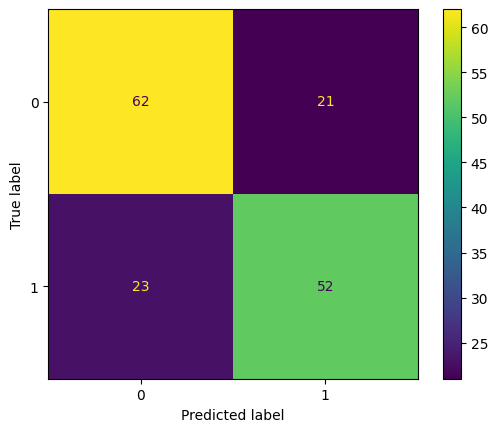

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix(targets, preds))

disp.plot()

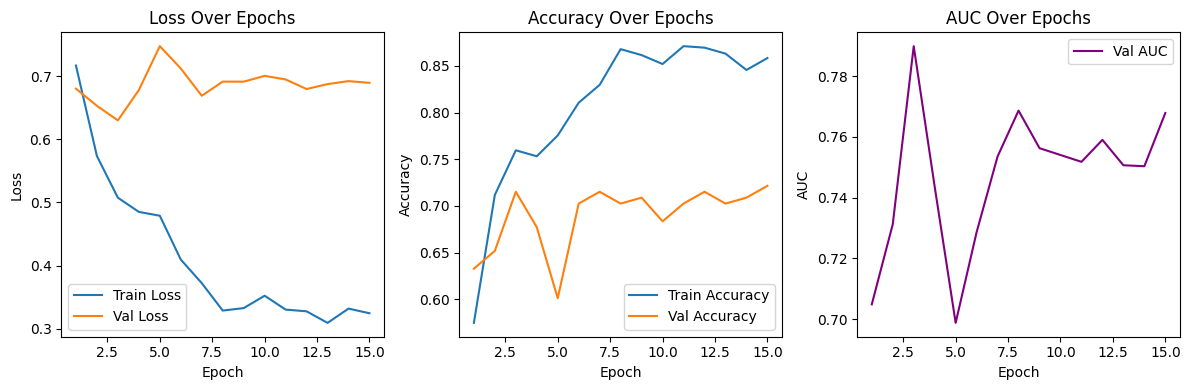

In [ ]:
epochs = range(1, len(train_loss_list) + 1)

# Plot Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, val_auc_list, label='Val AUC', color='purple')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model

ResNetBinary(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

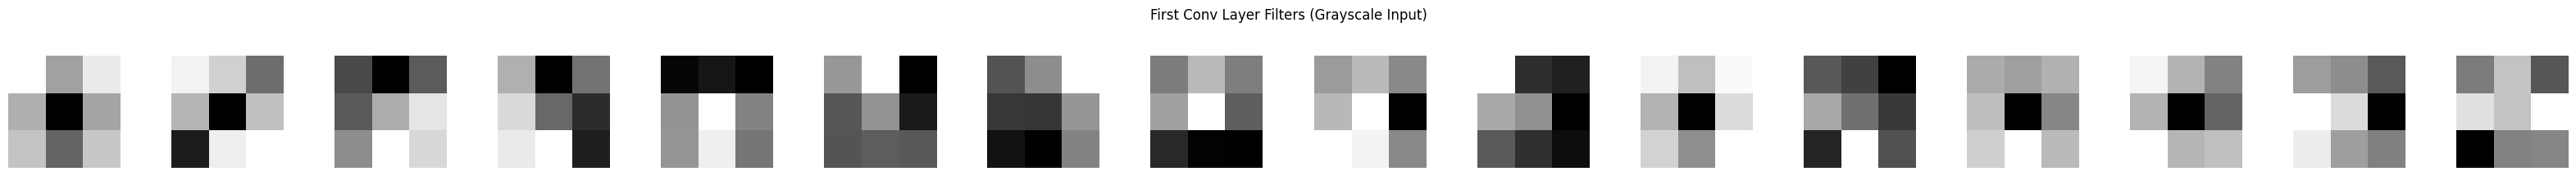

In [ ]:
#weights = model.model.conv1.weight.data.clone().cpu()
weights = model.model.layer1[0].conv2.weight.data.clone().cpu()
weights -= weights.min()
weights /= weights.max()
n_filters = 16  # Number of filters to visualize
fig, axes = plt.subplots(1, n_filters, figsize=(n_filters * 2, 2))

for i in range(n_filters):
    ax = axes[i]
    ax.imshow(weights[i, 0], cmap='gray')  # Use grayscale for 1-channel filters
    ax.axis('off')

plt.suptitle('First Conv Layer Filters (Grayscale Input)', y=1.05)
plt.tight_layout()
plt.show()

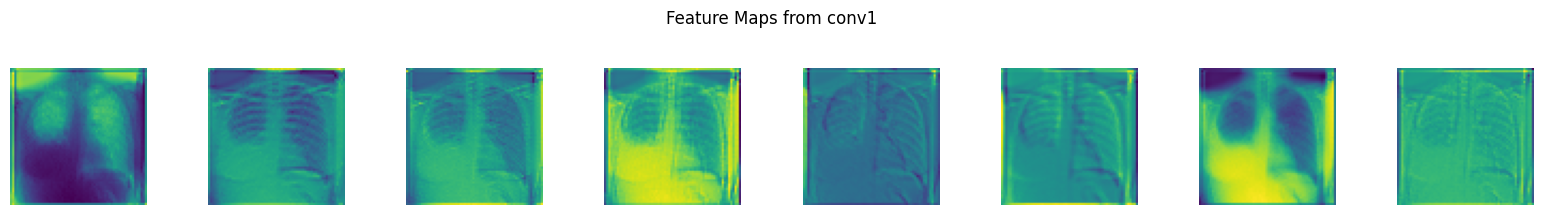

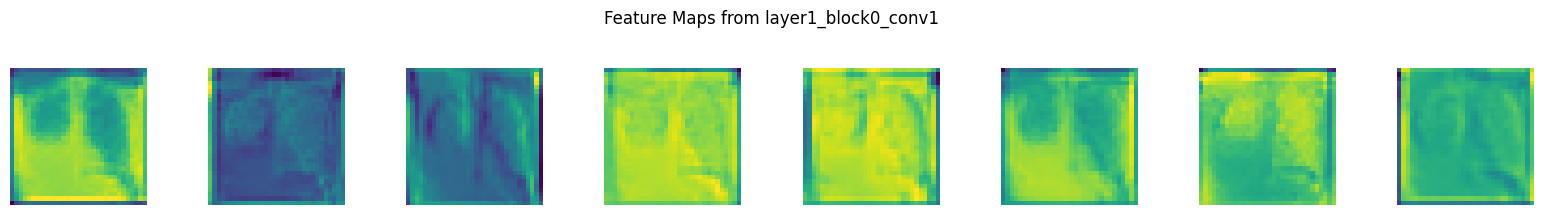

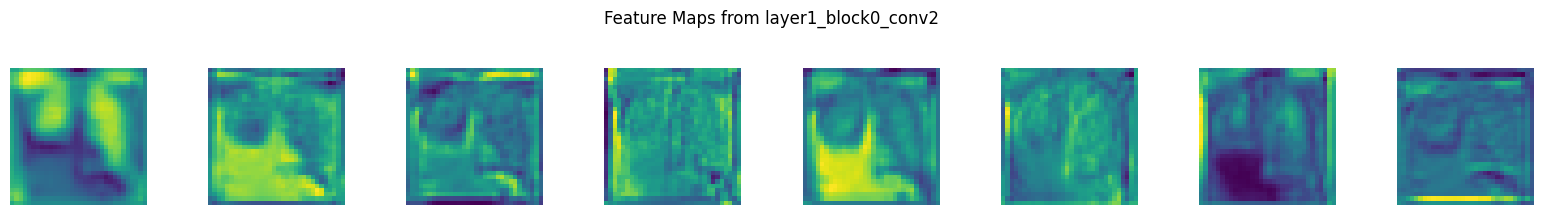

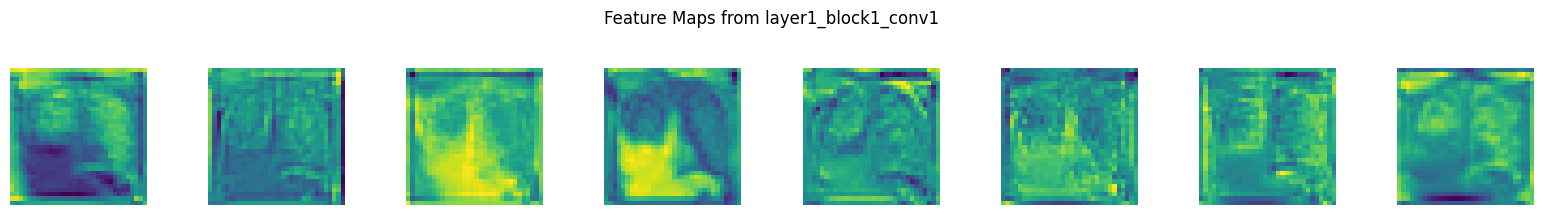

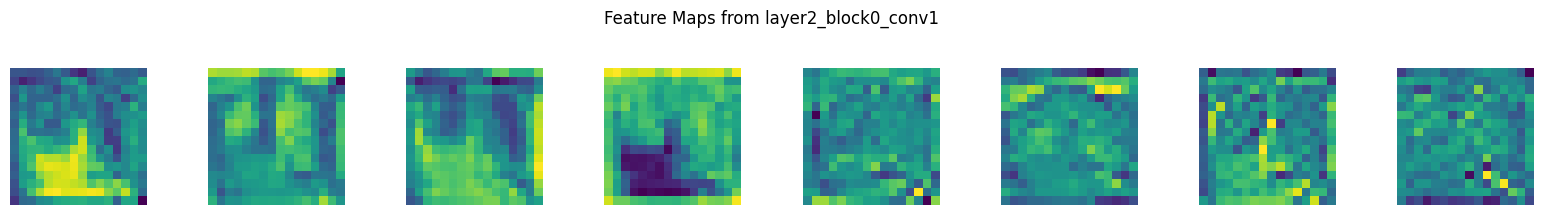

In [ ]:
images, labels = next(iter(val_loader))
image = images[6].unsqueeze(0).to(device)

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks for desired layers
model.model.conv1.register_forward_hook(get_activation("conv1"))
model.model.layer1[0].conv1.register_forward_hook(get_activation("layer1_block0_conv1"))
model.model.layer1[0].conv2.register_forward_hook(get_activation("layer1_block0_conv2"))
model.model.layer1[1].conv1.register_forward_hook(get_activation("layer1_block1_conv1"))
model.model.layer2[0].conv1.register_forward_hook(get_activation("layer2_block0_conv1"))


model.eval()
with torch.no_grad():
    _ = model(image)

def plot_feature_maps(feat_maps, layer_name, num_maps=8):
    fmap = feat_maps[layer_name].squeeze(0)  # [C, H, W]
    num_maps = min(num_maps, fmap.shape[0])

    fig, axes = plt.subplots(1, num_maps, figsize=(num_maps * 2, 2))
    for i in range(num_maps):
        axes[i].imshow(fmap[i].cpu(), cmap='viridis')
        axes[i].axis("off")
    plt.suptitle(f"Feature Maps from {layer_name}", y=1.05)
    plt.tight_layout()
    plt.show()

plot_feature_maps(activations, "conv1")
plot_feature_maps(activations, "layer1_block0_conv1")
plot_feature_maps(activations, "layer1_block0_conv2")
plot_feature_maps(activations, "layer1_block1_conv1")
plot_feature_maps(activations, "layer2_block0_conv1")

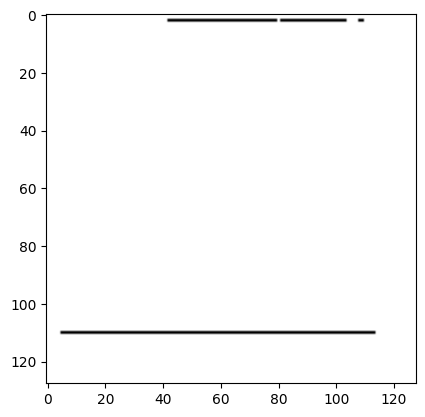

In [ ]:
test = np.array(images[6].squeeze(0).permute(1,2,0))
test

plt.imshow(test)

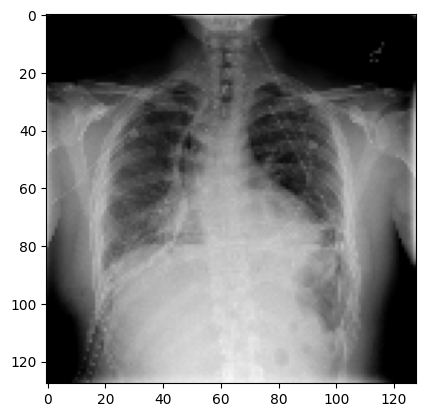

In [ ]:
plt.imshow(X[2])

array([[[ 45,  45,  45],
        [ 13,  13,  13],
        [  0,   0,   0],
        ...,
        [  4,   4,   4],
        [ 39,  39,  39],
        [122, 122, 122]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [ 31,  31,  31]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
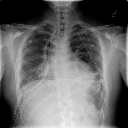

In [ ]:
X[2]

array([[[215, 215, 215],
        [208, 208, 208],
        [199, 199, 199],
        ...,
        [214, 214, 214],
        [214, 214, 214],
        [218, 218, 218]],

       [[202, 202, 202],
        [189, 189, 189],
        [154, 154, 154],
        ...,
        [202, 202, 202],
        [203, 203, 203],
        [204, 204, 204]],

       [[190, 190, 190],
        [173, 173, 173],
        [ 81,  81,  81],
        ...,
        [188, 188, 188],
        [189, 189, 189],
        [191, 191, 191]],

       ...,

       [[ 82,  82,  82],
        [ 14,  14,  14],
        [ 14,  14,  14],
        ...,
        [179, 179, 179],
        [183, 183, 183],
        [185, 185, 185]],

       [[ 81,  81,  81],
        [ 15,  15,  15],
        [ 13,  13,  13],
        ...,
        [182, 182, 182],
        [184, 184, 184],
        [185, 185, 185]],

       [[ 78,  78,  78],
        [ 13,  13,  13],
        [ 10,  10,  10],
        ...,
        [187, 187, 187],
        [188, 188, 188],
        [191, 191, 191]]], dtype=uint8)
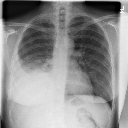

In [ ]:
val_imgs[6]